In [11]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [12]:
# Connect to the database
conn = sqlite3.connect('full_stock_history.db')

# Get basic information about the database
symbol_count = pd.read_sql_query("""
    SELECT COUNT(DISTINCT symbol) as symbol_count 
    FROM daily_prices
""", conn).iloc[0]['symbol_count']

date_range = pd.read_sql_query("""
    SELECT 
        MIN(date) as start_date,
        MAX(date) as end_date,
        COUNT(DISTINCT date) as trading_days
    FROM daily_prices
""", conn)

print(f"Database contains {symbol_count} unique symbols")
print(f"Date range: {date_range.iloc[0]['start_date']} to {date_range.iloc[0]['end_date']}")
print(f"Total trading days: {date_range.iloc[0]['trading_days']}")

Database contains 4251 unique symbols
Date range: 1927-12-30 to 2024-12-30
Total trading days: 24366


In [13]:
most_complete_stocks = pd.read_sql_query("""
    SELECT 
        symbol,
        COUNT(*) as data_points,
        MIN(date) as start_date,
        MAX(date) as end_date
    FROM daily_prices
    GROUP BY symbol
    HAVING data_points > 1000
    ORDER BY data_points DESC
    LIMIT 20
""", conn)

print("Stocks with most complete data:")
display(most_complete_stocks)


Stocks with most complete data:


,symbol,data_points,start_date,end_date
0,^GSPC,24366,1927-12-30,2024-12-30
1,AEP,15857,1962-01-02,2024-12-30
2,BA,15857,1962-01-02,2024-12-30
3,CAT,15857,1962-01-02,2024-12-30
4,CNP,15857,1962-01-02,2024-12-30
5,CVX,15857,1962-01-02,2024-12-30
6,DIS,15857,1962-01-02,2024-12-30
7,DTE,15857,1962-01-02,2024-12-30
8,ED,15857,1962-01-02,2024-12-30
9,GD,15857,1962-01-02,2024-12-30


<Figure size 1200x600 with 0 Axes>

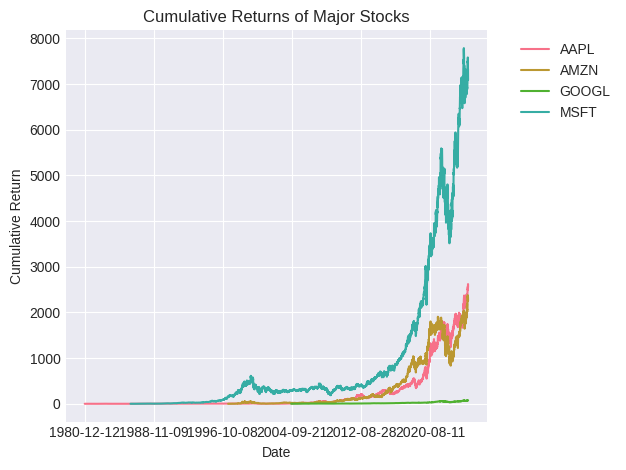

In [14]:
# Select a few major stocks (adjust based on your data)
major_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data = pd.read_sql_query(f"""
    SELECT date, symbol, close
    FROM daily_prices
    WHERE symbol IN {tuple(major_stocks)}
    ORDER BY date
""", conn)


# Pivot the data and calculate daily returns
stock_prices = stock_data.pivot(index='date', columns='symbol', values='close')
stock_returns = stock_prices.pct_change()

# Plot cumulative returns
cumulative_returns = (1 + stock_returns).cumprod()
plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Returns of Major Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
return_stats = stock_returns.agg(['mean', 'std', 'min', 'max']).T
return_stats['annualized_return'] = return_stats['mean'] * 252  # 252 trading days
return_stats['annualized_volatility'] = return_stats['std'] * np.sqrt(252)
display(return_stats)

,mean,std,min,max,annualized_return,annualized_volatility
symbol,,,,,,
AAPL,0.001099,0.027785,-0.518692,0.332281,0.277031,0.441076
AMZN,0.001721,0.035246,-0.247661,0.344714,0.433743,0.559515
GOOGL,0.001031,0.019270,-0.116342,0.199915,0.259771,0.305895
MSFT,0.001129,0.021031,-0.301158,0.195652,0.284545,0.333851


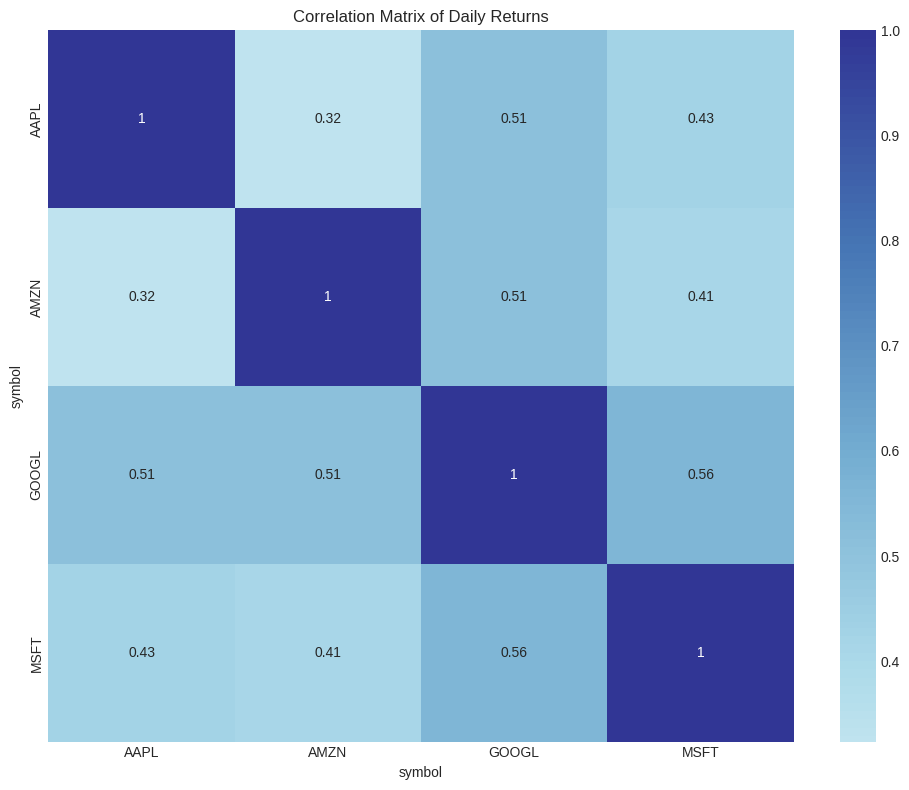

In [16]:
correlation_matrix = stock_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.tight_layout()
plt.show()

In [17]:
volume_data = pd.read_sql_query(f"""
    SELECT 
        date,
        symbol,
        volume,
        volume * close as dollar_volume
    FROM daily_prices
    WHERE symbol IN {tuple(major_stocks)}
    AND date >= date('now', '-1 year')
    ORDER BY date
""", conn)

# Calculate average daily dollar volume
avg_dollar_volume = volume_data.groupby('symbol')['dollar_volume'].mean()
print("\nAverage Daily Dollar Volume (Last Year):")
display(avg_dollar_volume.sort_values(ascending=False))


Average Daily Dollar Volume (Last Year):


symbol
AAPL     1.167302e+10
MSFT     8.620229e+09
AMZN     7.534412e+09
GOOGL    4.460552e+09
Name: dollar_volume, dtype: float64

<Figure size 1200x600 with 0 Axes>

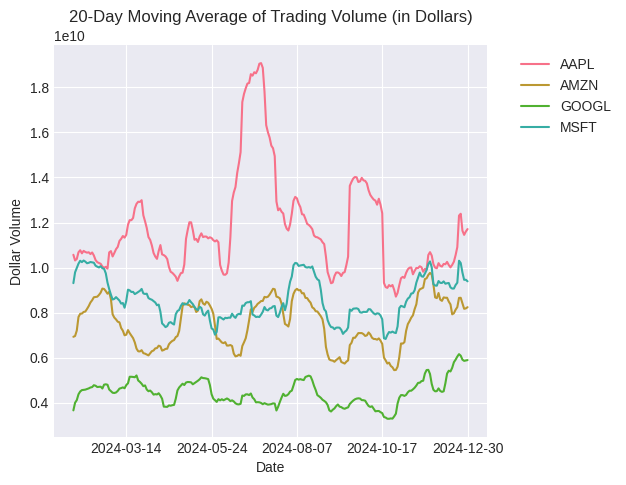

In [18]:
# Plot volume trends
volume_trends = volume_data.pivot(index='date', columns='symbol', values='dollar_volume')
plt.figure(figsize=(12, 6))
volume_trends.rolling(window=20).mean().plot()
plt.title('20-Day Moving Average of Trading Volume (in Dollars)')
plt.xlabel('Date')
plt.ylabel('Dollar Volume')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

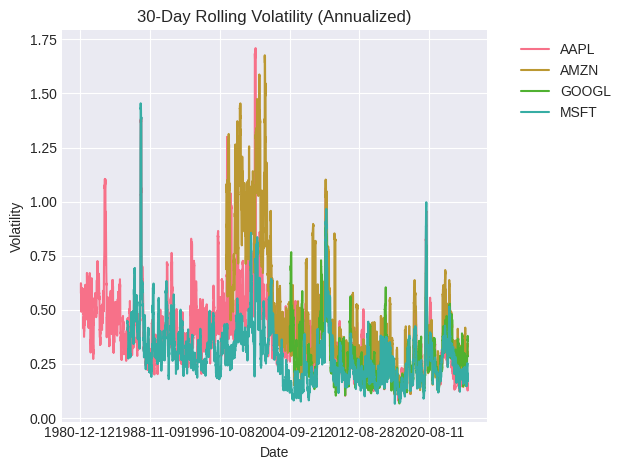

In [19]:
# Calculate rolling 30-day volatility
volatility = stock_returns.rolling(window=30).std() * np.sqrt(252)  # Annualized

plt.figure(figsize=(12, 6))
volatility.plot()
plt.title('30-Day Rolling Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
def calculate_drawdowns(prices):
    rolling_max = prices.cummax()
    drawdowns = prices / rolling_max - 1.0
    return drawdowns

drawdowns = calculate_drawdowns(stock_prices)
worst_drawdowns = drawdowns.min()
print("\nWorst Drawdowns:")
display(worst_drawdowns.sort_values())

# Don't forget to close the connection
conn.close()


Worst Drawdowns:


symbol
AMZN    -0.944042
AAPL    -0.818014
MSFT    -0.693862
GOOGL   -0.652948
dtype: float64